In [18]:
# Re-import necessary libraries
import pandas as pd

# Reload the dataset
file_path = "data/gspc_hourly_with_indicators.csv"
df = pd.read_csv(file_path, index_col=0, parse_dates=[0])

df['Date'] = df.index.date  # Extract date to group by day
df["Target"] = df["Target"]+1
# Compute previous day's High, Low, Close
daily_pivot_data = df.groupby('Date').agg({'High': 'max', 'Low': 'min', 'Close': 'last'}).shift(1)

# Merge back to hourly data, ensuring the pivot points remain constant throughout the day
df = df.merge(daily_pivot_data, left_on='Date', right_index=True, suffixes=('', '_prev_day'))

# Calculate Corrected Daily Pivot Points
df['Pivot'] = (df['High_prev_day'] + df['Low_prev_day'] + df['Close_prev_day']) / 3
df['S1'] = (2 * df['Pivot']) - df['High_prev_day']
df['R1'] = (2 * df['Pivot']) - df['Low_prev_day']
df['S2'] = df['Pivot'] - (df['High_prev_day'] - df['Low_prev_day'])
df['R2'] = df['Pivot'] + (df['High_prev_day'] - df['Low_prev_day'])

# Drop columns used for calculations to keep dataset clean
df.drop(columns=['High_prev_day', 'Low_prev_day', 'Close_prev_day'], inplace=True)

# Compute distances from pivot points
df['Dist_Pivot'] = df['Close'] - df['Pivot']
df['Dist_R1'] = df['Close'] - df['R1']

# Compute ATR (for normalization)
df['ATR_14'] = (df['High'] - df['Low']).rolling(window=14).mean()

# Normalize distances using ATR
df['Norm_Dist_Pivot'] = df['Dist_Pivot'] / df['ATR_14']
df['Norm_Dist_R1'] = df['Dist_R1'] / df['ATR_14']

# Compute 'Change', 'Slope', 'Acceleration'
df['Change'] = df['Close'].pct_change()
df['Slope'] = df['Close'].diff()
df['Acceleration'] = df['Slope'].diff()

# Drop NaN values resulting from shifting and rolling calculations
selected_features = ['Change', 'Slope', 'Acceleration', 'Norm_Dist_Pivot', 'Norm_Dist_R1']
df.dropna(subset=selected_features, inplace=True)



Using cpu device


AttributeError: 'TradingEnv' object has no attribute '_next_observation'

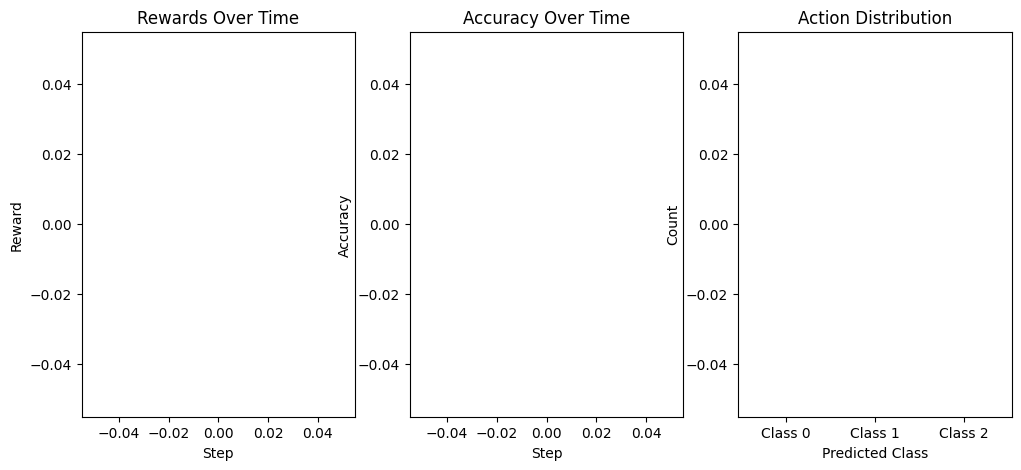

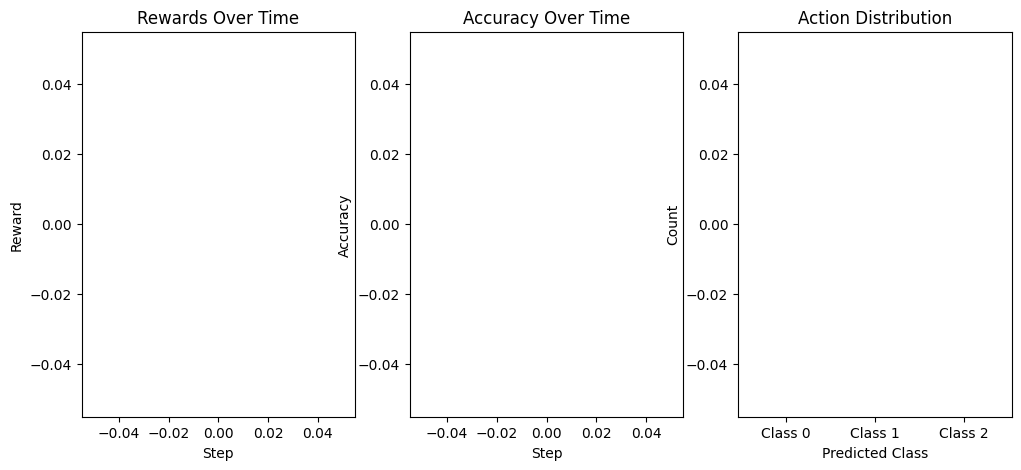

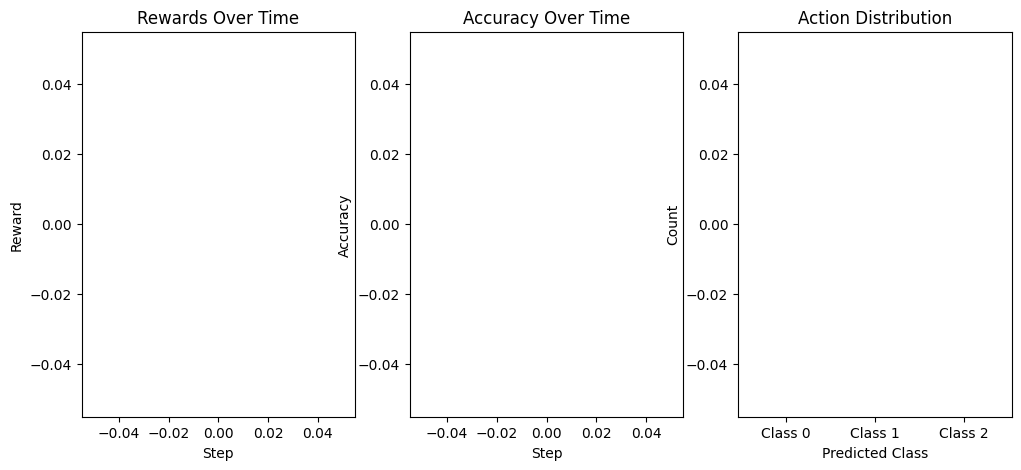

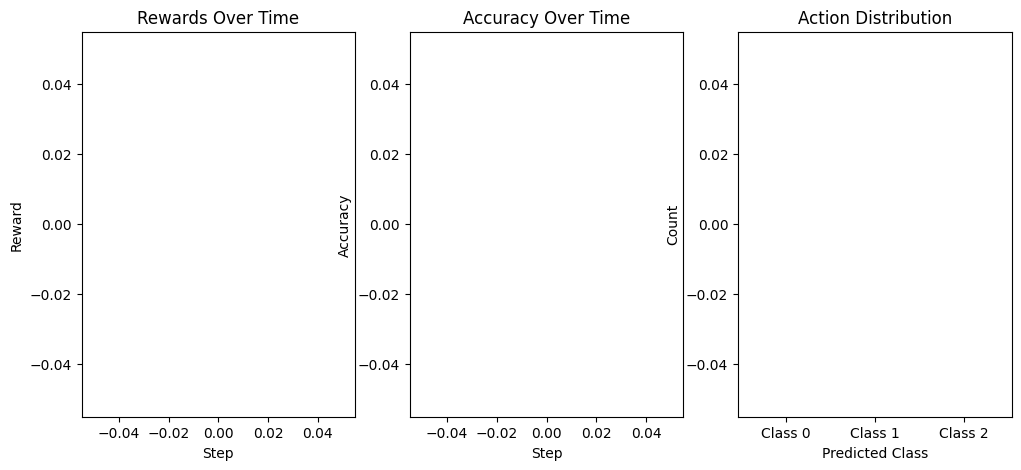

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sklearn.preprocessing import StandardScaler
from stable_baselines3.common.env_util import make_vec_env


def reward_function(predicted: int, actual: int) -> float:
    """
    Custom reward function for reinforcement learning agent.

    Args:
    - predicted (int): Model's predicted class (0, 1, or 2).
    - actual (int): True class label.

    Returns:
    - float: Reward value.
    """

    # Reward for correctly predicting class 0 or 2
    if predicted == actual:
        if actual in {0, 2}:
            return 5.0  # Higher reward for these
        else:
            return 2.0  # Lower reward for correctly predicting class 1

    # Penalize incorrect predictions
    if actual in {0, 2}:
        return -3.0  # Higher penalty for misclassifying 0 or 2
    else:
        return -1.0  # Smaller penalty for misclassifying class 1

    return 0.0  # Default case


def entropy_penalty(action_probs: np.ndarray) -> float:
    """
    Adds an entropy penalty to encourage exploration.

    Args:
    - action_probs (np.ndarray): Probability distribution of actions.

    Returns:
    - float: Entropy penalty.
    """
    entropy = -np.sum(action_probs * np.log(action_probs + 1e-8))  # Avoid log(0)
    return entropy * 0.5  # Scale entropy contribution




class TradingEnv(gym.Env):
    """Gymnasium Environment for Reinforcement Learning on financial data."""
    
    def __init__(self, df: pd.DataFrame, render_interval=5000):
        super(TradingEnv, self).__init__()

        self.df = df
        self.current_step = 0
        self.render_interval = render_interval  # How often to render
        
        # Tracking metrics
        self.total_rewards = []
        self.accuracy_history = []
        self.prediction_counts = {0: 0, 1: 0, 2: 0}
        self.correct_counts = {0: 0, 1: 0, 2: 0}
        self.total_counts = {0: 0, 1: 0, 2: 0}
        
        # Observation space: 5 continuous features
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32)

        # Action space: Discrete choices (0, 1, 2)
        self.action_space = spaces.Discrete(3)

    def reset(self, seed=None, options=None):
        """Reset the environment, clear stats, and return the first observation."""
        super().reset(seed=seed)
        self.current_step = 0
        self.total_rewards = []
        self.accuracy_history = []
        self.prediction_counts = {0: 0, 1: 0, 2: 0}
        self.correct_counts = {0: 0, 1: 0, 2: 0}
        self.total_counts = {0: 0, 1: 0, 2: 0}
        return self._next_observation(), {}

    def _next_observation(self):
        """Get the next observation."""
        return self.df.iloc[self.current_step, :-1].values.astype(np.float32)

    def step(self, action):
        """Execute action, return next state, reward, and done flag."""
        actual = self.df.iloc[self.current_step]["Target"]
        reward = reward_function(action, actual)

        # Track rewards
        self.total_rewards.append(reward)

        # Track accuracy
        self.prediction_counts[action] += 1
        self.total_counts[actual] += 1
        if action == actual:
            self.correct_counts[actual] += 1

        accuracy = sum(self.correct_counts.values()) / sum(self.total_counts.values()) if sum(self.total_counts.values()) > 0 else 0
        self.accuracy_history.append(accuracy)

        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        truncated = False

        # Occasionally render stats
        if self.current_step % self.render_interval == 0:
            self.render()

        return self._next_observation(), reward, done, truncated, {"accuracy": accuracy}

    def render(self):
        """Visualize training progress periodically."""
        if not self.total_rewards:
            return  # No data to render yet
        self.reward_line.set_xdata(range(len(self.total_rewards)))
        self.reward_line.set_ydata(self.total_rewards)
        self.axs[0].relim()
        self.axs[0].autoscale_view()

        # Update Accuracy Plot
        self.accuracy_line.set_xdata(range(len(self.accuracy_history)))
        self.accuracy_line.set_ydata(self.accuracy_history)
        self.axs[1].relim()
        self.axs[1].autoscale_view()

        # Update Action Distribution Bar Chart
        for i, bar in enumerate(self.bar_container):
            bar.set_height(self.prediction_counts[i])

        # Pause to update the plot
        plt.pause(0.1)

def make_env(df):
    """Function to create a new instance of the environment."""
    return lambda: TradingEnv(df)



# Normalize features (excluding Target)
scaler = StandardScaler()
df = df[['Change', 'Momentum', 'Acceleration', 'Norm_Dist_Pivot', 'Norm_Dist_R1', 'Target']]
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])


# Create a vectorized environment with multiple independent instances
vec_env = make_vec_env(make_env(df), n_envs=4)


# Define the model using LSTM-based policy
model = RecurrentPPO("MlpLstmPolicy", vec_env, verbose=1, device="cpu")

# Train the model
model.learn(total_timesteps=100000)

# Save the model
model.save("ppo_lstm_trading")



Action: 0, Reward: 5.0, Accuracy: 1.0000
Action: 2, Reward: -1.0, Accuracy: 0.5000
Action: 2, Reward: 5.0, Accuracy: 0.6667
Action: 0, Reward: -1.0, Accuracy: 0.5000
Action: 1, Reward: 2.0, Accuracy: 0.6000
Action: 2, Reward: -1.0, Accuracy: 0.5000
Action: 1, Reward: 2.0, Accuracy: 0.5714
Action: 1, Reward: 2.0, Accuracy: 0.6250
Action: 2, Reward: 5.0, Accuracy: 0.6667
Action: 0, Reward: -1.0, Accuracy: 0.6000
Action: 0, Reward: 5.0, Accuracy: 0.6364
Action: 2, Reward: -1.0, Accuracy: 0.5833
Action: 2, Reward: -1.0, Accuracy: 0.5385
Action: 2, Reward: -1.0, Accuracy: 0.5000
Action: 2, Reward: 5.0, Accuracy: 0.5333
Action: 0, Reward: -1.0, Accuracy: 0.5000
Action: 1, Reward: 2.0, Accuracy: 0.5294
Action: 1, Reward: 2.0, Accuracy: 0.5556
Action: 0, Reward: -1.0, Accuracy: 0.5263
Action: 1, Reward: 2.0, Accuracy: 0.5500
Action: 0, Reward: -1.0, Accuracy: 0.5238
Action: 0, Reward: -1.0, Accuracy: 0.5000
Action: 1, Reward: -3.0, Accuracy: 0.4783
Action: 2, Reward: -1.0, Accuracy: 0.4583
Act

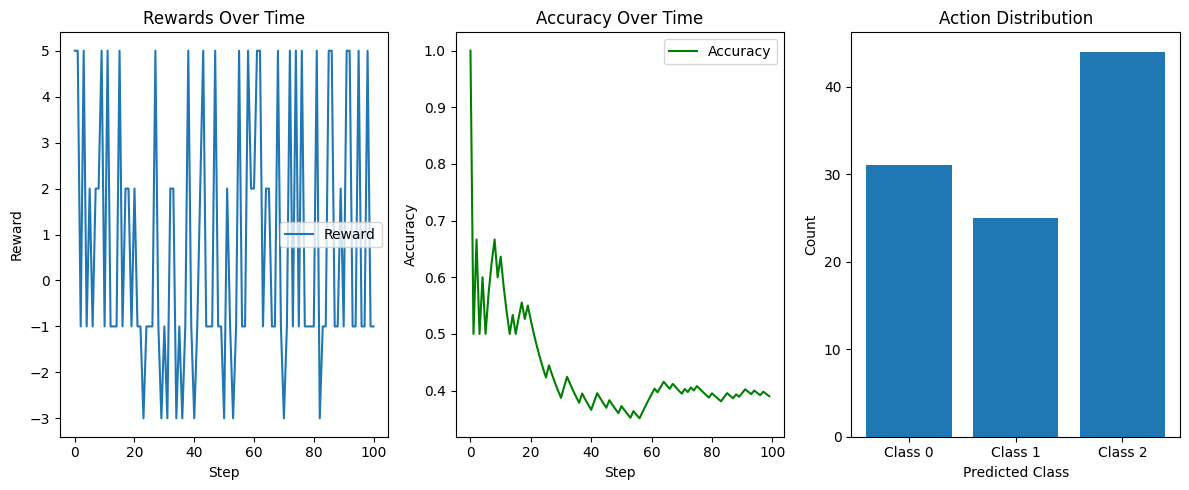

Action: 2, Reward: -1.0, Accuracy: 0.3900
Action: 2, Reward: -1.0, Accuracy: 0.3861
Action: 2, Reward: -1.0, Accuracy: 0.3824
Action: 1, Reward: -3.0, Accuracy: 0.3786
Action: 0, Reward: -1.0, Accuracy: 0.3750
Action: 0, Reward: -1.0, Accuracy: 0.3714
Action: 1, Reward: 2.0, Accuracy: 0.3774
Action: 0, Reward: 5.0, Accuracy: 0.3832
Action: 2, Reward: -1.0, Accuracy: 0.3796
Action: 0, Reward: -1.0, Accuracy: 0.3761
Action: 2, Reward: 5.0, Accuracy: 0.3818
Action: 0, Reward: -1.0, Accuracy: 0.3784
Action: 1, Reward: 2.0, Accuracy: 0.3839
Action: 1, Reward: 2.0, Accuracy: 0.3894
Action: 0, Reward: -1.0, Accuracy: 0.3860
Action: 0, Reward: -1.0, Accuracy: 0.3826
Action: 1, Reward: 2.0, Accuracy: 0.3879
Action: 2, Reward: 5.0, Accuracy: 0.3932
Action: 0, Reward: -1.0, Accuracy: 0.3898
Action: 1, Reward: -3.0, Accuracy: 0.3866
Action: 2, Reward: -1.0, Accuracy: 0.3833
Action: 1, Reward: 2.0, Accuracy: 0.3884
Action: 1, Reward: 2.0, Accuracy: 0.3934
Action: 2, Reward: 5.0, Accuracy: 0.3984
Ac

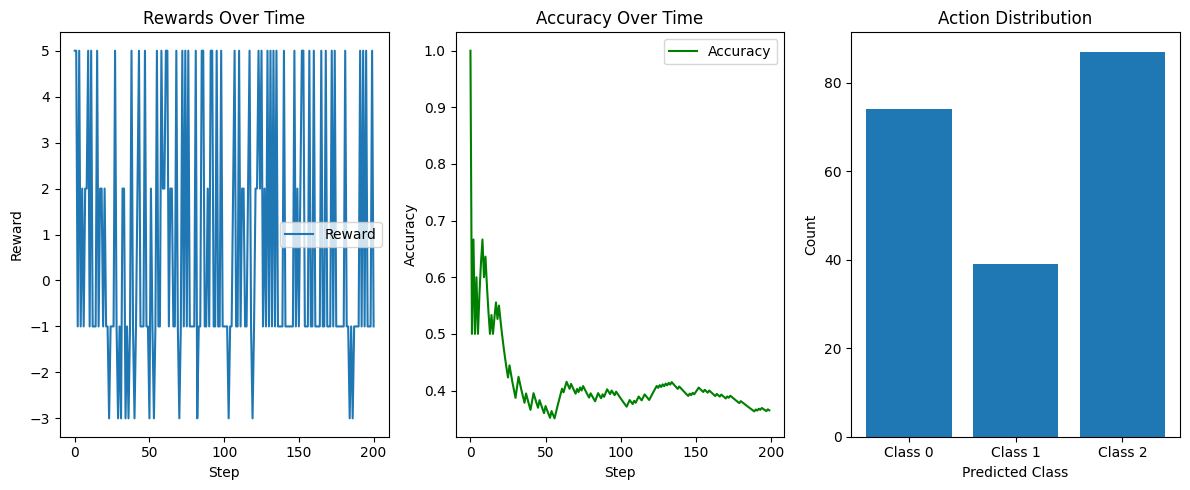

Action: 0, Reward: -1.0, Accuracy: 0.3650
Action: 1, Reward: 2.0, Accuracy: 0.3682
Action: 2, Reward: -1.0, Accuracy: 0.3663
Action: 0, Reward: -1.0, Accuracy: 0.3645
Action: 0, Reward: 5.0, Accuracy: 0.3676
Action: 2, Reward: -1.0, Accuracy: 0.3659
Action: 2, Reward: -1.0, Accuracy: 0.3641
Action: 2, Reward: -1.0, Accuracy: 0.3623
Action: 2, Reward: 5.0, Accuracy: 0.3654
Action: 0, Reward: 5.0, Accuracy: 0.3684
Action: 2, Reward: -1.0, Accuracy: 0.3667
Action: 2, Reward: -1.0, Accuracy: 0.3649
Action: 2, Reward: -1.0, Accuracy: 0.3632
Action: 1, Reward: -3.0, Accuracy: 0.3615
Action: 1, Reward: 2.0, Accuracy: 0.3645
Action: 0, Reward: -1.0, Accuracy: 0.3628
Action: 0, Reward: -1.0, Accuracy: 0.3611
Action: 0, Reward: -1.0, Accuracy: 0.3594
Action: 2, Reward: 5.0, Accuracy: 0.3624
Action: 0, Reward: 5.0, Accuracy: 0.3653
Action: 2, Reward: -1.0, Accuracy: 0.3636
Action: 2, Reward: -1.0, Accuracy: 0.3620
Action: 2, Reward: 5.0, Accuracy: 0.3649
Action: 0, Reward: 5.0, Accuracy: 0.3677
A

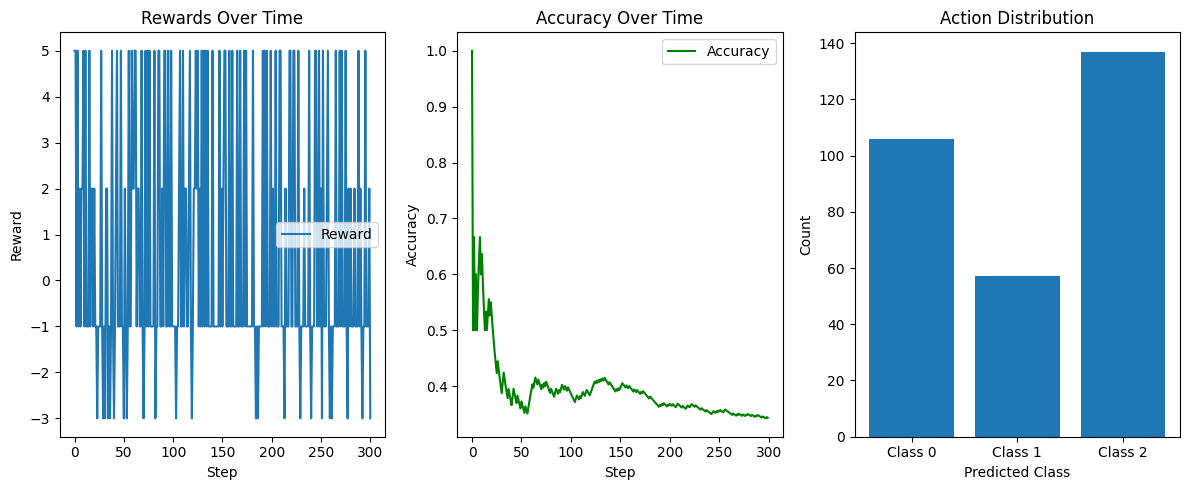

Action: 1, Reward: -3.0, Accuracy: 0.3433
Action: 2, Reward: 5.0, Accuracy: 0.3455
Action: 0, Reward: -1.0, Accuracy: 0.3444
Action: 1, Reward: 2.0, Accuracy: 0.3465
Action: 0, Reward: -1.0, Accuracy: 0.3454
Action: 2, Reward: 5.0, Accuracy: 0.3475
Action: 0, Reward: -1.0, Accuracy: 0.3464
Action: 0, Reward: 5.0, Accuracy: 0.3485
Action: 2, Reward: -1.0, Accuracy: 0.3474
Action: 2, Reward: -1.0, Accuracy: 0.3463
Action: 2, Reward: -1.0, Accuracy: 0.3452
Action: 0, Reward: -1.0, Accuracy: 0.3441
Action: 2, Reward: 5.0, Accuracy: 0.3462
Action: 0, Reward: -1.0, Accuracy: 0.3450
Action: 1, Reward: 2.0, Accuracy: 0.3471
Action: 2, Reward: -1.0, Accuracy: 0.3460
Action: 2, Reward: -1.0, Accuracy: 0.3449
Action: 0, Reward: 5.0, Accuracy: 0.3470
Action: 2, Reward: 5.0, Accuracy: 0.3491
Action: 0, Reward: -1.0, Accuracy: 0.3480
Action: 1, Reward: 2.0, Accuracy: 0.3500
Action: 2, Reward: -1.0, Accuracy: 0.3489
Action: 2, Reward: -1.0, Accuracy: 0.3478
Action: 2, Reward: -1.0, Accuracy: 0.3467
A

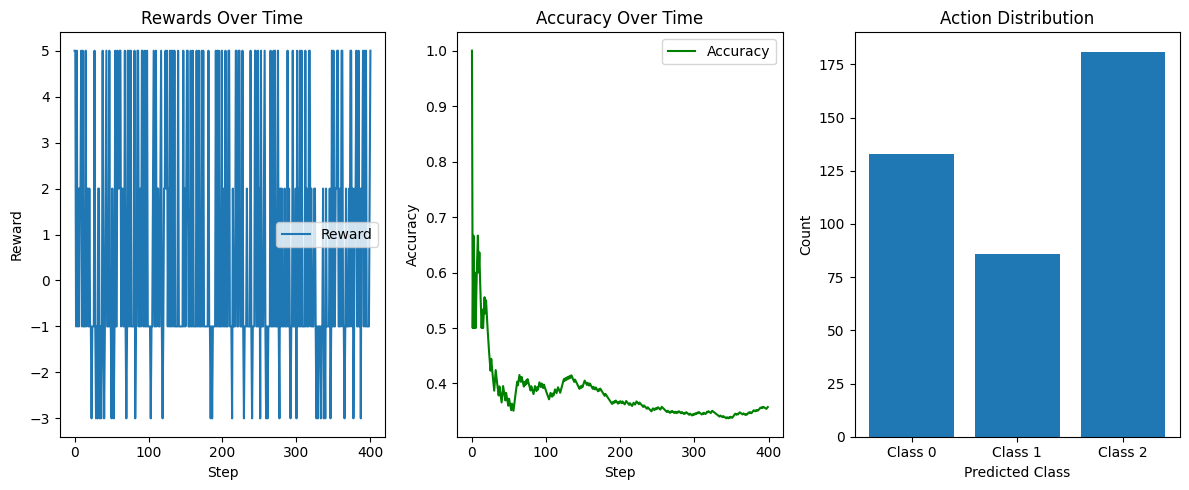

Action: 2, Reward: 5.0, Accuracy: 0.3575
Action: 1, Reward: 2.0, Accuracy: 0.3591
Action: 1, Reward: -3.0, Accuracy: 0.3582
Action: 1, Reward: 2.0, Accuracy: 0.3598
Action: 1, Reward: -3.0, Accuracy: 0.3589
Action: 1, Reward: 2.0, Accuracy: 0.3605
Action: 0, Reward: -1.0, Accuracy: 0.3596
Action: 0, Reward: -1.0, Accuracy: 0.3587
Action: 1, Reward: -3.0, Accuracy: 0.3578
Action: 2, Reward: -1.0, Accuracy: 0.3570
Action: 1, Reward: 2.0, Accuracy: 0.3585
Action: 2, Reward: -1.0, Accuracy: 0.3577
Action: 1, Reward: 2.0, Accuracy: 0.3592
Action: 2, Reward: -1.0, Accuracy: 0.3584
Action: 2, Reward: -1.0, Accuracy: 0.3575
Action: 1, Reward: 2.0, Accuracy: 0.3590
Action: 2, Reward: -1.0, Accuracy: 0.3582
Action: 2, Reward: 5.0, Accuracy: 0.3597
Action: 0, Reward: -1.0, Accuracy: 0.3589
Action: 0, Reward: -1.0, Accuracy: 0.3580
Action: 2, Reward: -1.0, Accuracy: 0.3571
Action: 1, Reward: 2.0, Accuracy: 0.3587
Action: 1, Reward: -3.0, Accuracy: 0.3578
Action: 2, Reward: -1.0, Accuracy: 0.3570
A

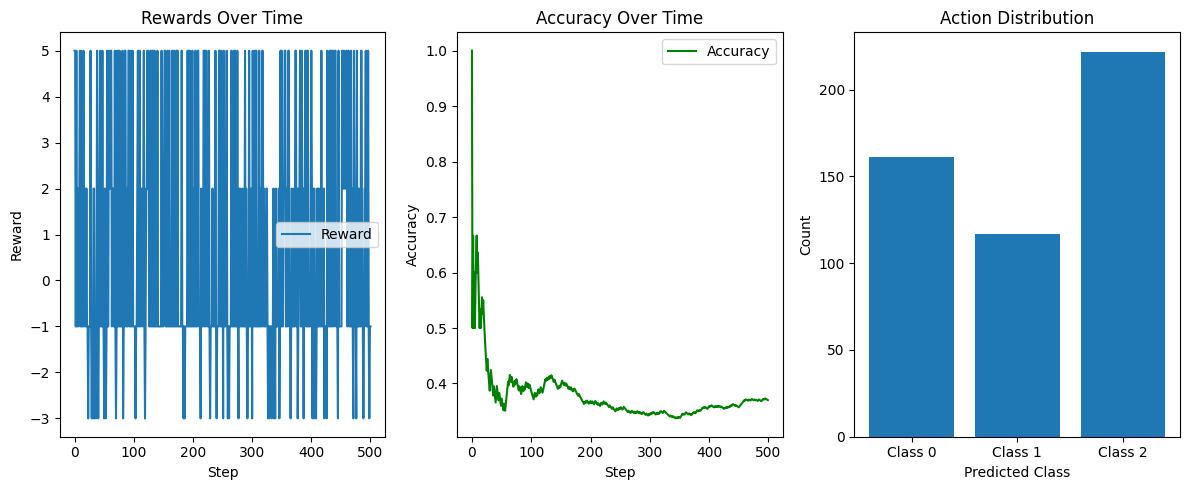

Action: 2, Reward: -1.0, Accuracy: 0.3700
Action: 2, Reward: -1.0, Accuracy: 0.3693
Action: 2, Reward: -1.0, Accuracy: 0.3685
Action: 2, Reward: -1.0, Accuracy: 0.3678
Action: 1, Reward: -3.0, Accuracy: 0.3671
Action: 0, Reward: -1.0, Accuracy: 0.3663
Action: 0, Reward: -1.0, Accuracy: 0.3656
Action: 1, Reward: -3.0, Accuracy: 0.3649
Action: 1, Reward: 2.0, Accuracy: 0.3661
Action: 1, Reward: -3.0, Accuracy: 0.3654
Action: 0, Reward: -1.0, Accuracy: 0.3647
Action: 2, Reward: -1.0, Accuracy: 0.3640
Action: 1, Reward: 2.0, Accuracy: 0.3652
Action: 2, Reward: -1.0, Accuracy: 0.3645
Action: 0, Reward: -1.0, Accuracy: 0.3638
Action: 2, Reward: 5.0, Accuracy: 0.3650
Action: 1, Reward: 2.0, Accuracy: 0.3663
Action: 0, Reward: 5.0, Accuracy: 0.3675
Action: 2, Reward: -1.0, Accuracy: 0.3668
Action: 0, Reward: -1.0, Accuracy: 0.3661
Action: 2, Reward: 5.0, Accuracy: 0.3673
Action: 0, Reward: -1.0, Accuracy: 0.3666
Action: 0, Reward: 5.0, Accuracy: 0.3678
Action: 2, Reward: -1.0, Accuracy: 0.3671

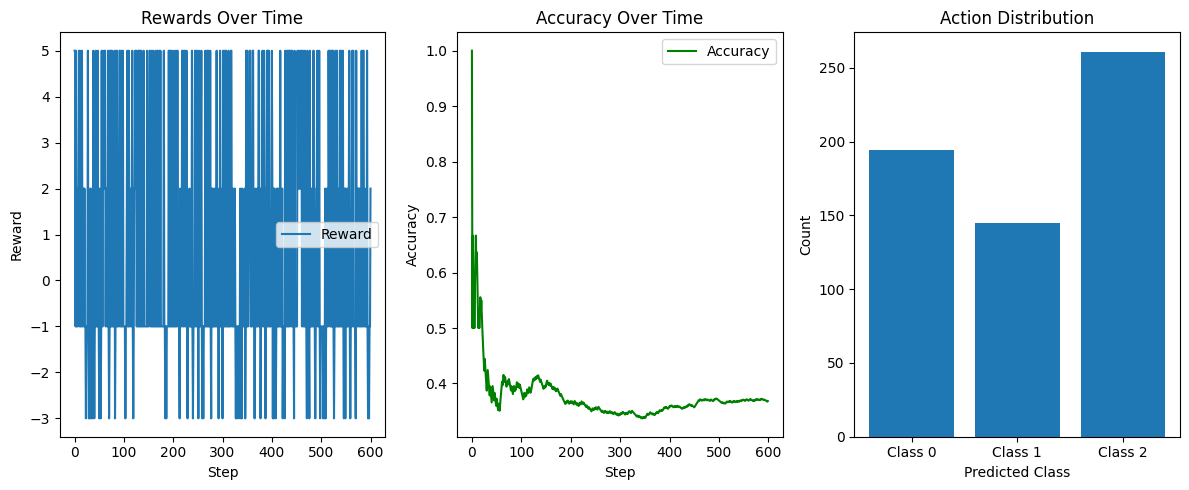

Action: 1, Reward: 2.0, Accuracy: 0.3683
Action: 0, Reward: 5.0, Accuracy: 0.3694
Action: 2, Reward: -1.0, Accuracy: 0.3688
Action: 2, Reward: -1.0, Accuracy: 0.3682
Action: 2, Reward: -1.0, Accuracy: 0.3675
Action: 0, Reward: 5.0, Accuracy: 0.3686
Action: 2, Reward: 5.0, Accuracy: 0.3696
Action: 0, Reward: -1.0, Accuracy: 0.3690
Action: 0, Reward: -1.0, Accuracy: 0.3684
Action: 0, Reward: -1.0, Accuracy: 0.3678
Action: 1, Reward: 2.0, Accuracy: 0.3689
Action: 1, Reward: -3.0, Accuracy: 0.3682
Action: 1, Reward: -3.0, Accuracy: 0.3676
Action: 1, Reward: 2.0, Accuracy: 0.3687
Action: 1, Reward: 2.0, Accuracy: 0.3697
Action: 1, Reward: 2.0, Accuracy: 0.3707
Action: 0, Reward: -1.0, Accuracy: 0.3701
Action: 0, Reward: -1.0, Accuracy: 0.3695
Action: 2, Reward: -3.0, Accuracy: 0.3689
Action: 2, Reward: -1.0, Accuracy: 0.3683
Action: 2, Reward: -1.0, Accuracy: 0.3677
Action: 1, Reward: -3.0, Accuracy: 0.3671
Action: 1, Reward: -3.0, Accuracy: 0.3666
Action: 2, Reward: -1.0, Accuracy: 0.3660


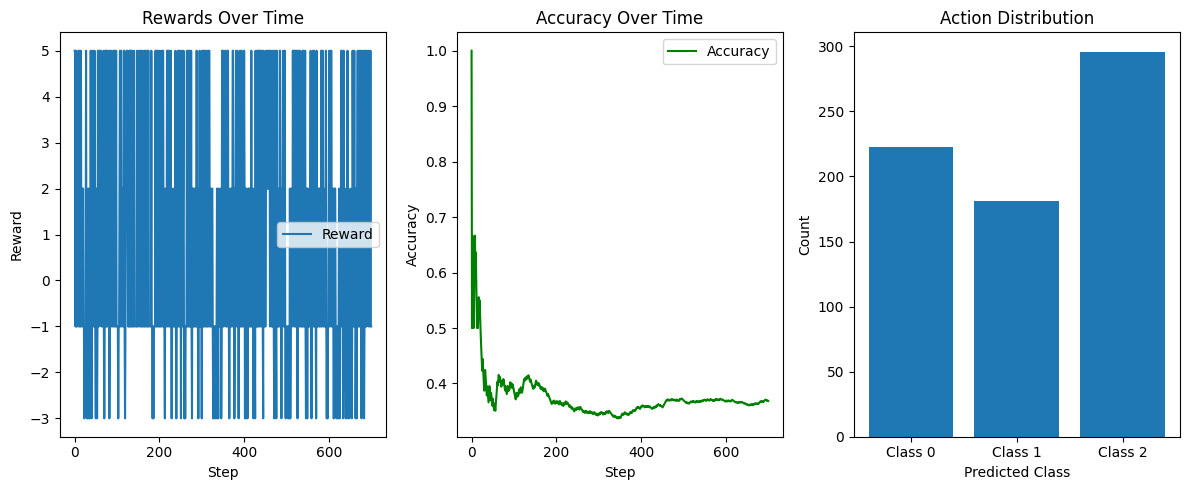

Action: 2, Reward: -1.0, Accuracy: 0.3686
Action: 2, Reward: -1.0, Accuracy: 0.3680
Action: 1, Reward: -3.0, Accuracy: 0.3675
Action: 1, Reward: -3.0, Accuracy: 0.3670
Action: 0, Reward: -1.0, Accuracy: 0.3665
Action: 0, Reward: -1.0, Accuracy: 0.3660
Action: 1, Reward: 2.0, Accuracy: 0.3669
Action: 0, Reward: 5.0, Accuracy: 0.3678
Action: 2, Reward: -1.0, Accuracy: 0.3672
Action: 2, Reward: -1.0, Accuracy: 0.3667
Action: 1, Reward: -3.0, Accuracy: 0.3662
Action: 0, Reward: 5.0, Accuracy: 0.3671
Action: 2, Reward: -1.0, Accuracy: 0.3666
Action: 1, Reward: 2.0, Accuracy: 0.3675
Action: 2, Reward: -1.0, Accuracy: 0.3669
Action: 2, Reward: 5.0, Accuracy: 0.3678
Action: 0, Reward: 5.0, Accuracy: 0.3687
Action: 1, Reward: 2.0, Accuracy: 0.3696
Action: 0, Reward: -1.0, Accuracy: 0.3691
Action: 1, Reward: 2.0, Accuracy: 0.3700
Action: 0, Reward: -1.0, Accuracy: 0.3694
Action: 0, Reward: -1.0, Accuracy: 0.3689
Action: 1, Reward: 2.0, Accuracy: 0.3698
Action: 0, Reward: -1.0, Accuracy: 0.3693
A

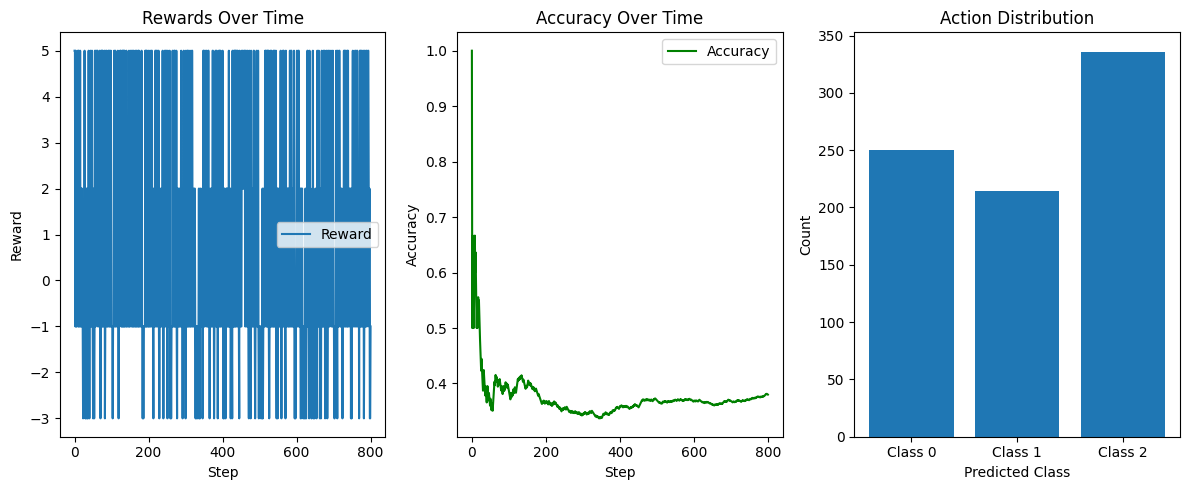

Action: 2, Reward: -1.0, Accuracy: 0.3800
Action: 1, Reward: 2.0, Accuracy: 0.3808
Action: 1, Reward: 2.0, Accuracy: 0.3815
Action: 2, Reward: 5.0, Accuracy: 0.3823
Action: 0, Reward: 5.0, Accuracy: 0.3831
Action: 2, Reward: -1.0, Accuracy: 0.3826
Action: 0, Reward: -1.0, Accuracy: 0.3821
Action: 1, Reward: 2.0, Accuracy: 0.3829
Action: 0, Reward: 5.0, Accuracy: 0.3837
Action: 2, Reward: 5.0, Accuracy: 0.3844
Action: 0, Reward: -1.0, Accuracy: 0.3840
Action: 2, Reward: -1.0, Accuracy: 0.3835
Action: 1, Reward: 2.0, Accuracy: 0.3842
Action: 1, Reward: -3.0, Accuracy: 0.3838
Action: 2, Reward: 5.0, Accuracy: 0.3845
Action: 0, Reward: -1.0, Accuracy: 0.3840
Action: 0, Reward: -1.0, Accuracy: 0.3836
Action: 0, Reward: -1.0, Accuracy: 0.3831
Action: 1, Reward: 2.0, Accuracy: 0.3839
Action: 1, Reward: -3.0, Accuracy: 0.3834
Action: 0, Reward: 5.0, Accuracy: 0.3841
Action: 2, Reward: -1.0, Accuracy: 0.3837
Action: 0, Reward: -1.0, Accuracy: 0.3832
Action: 1, Reward: 2.0, Accuracy: 0.3840
Acti

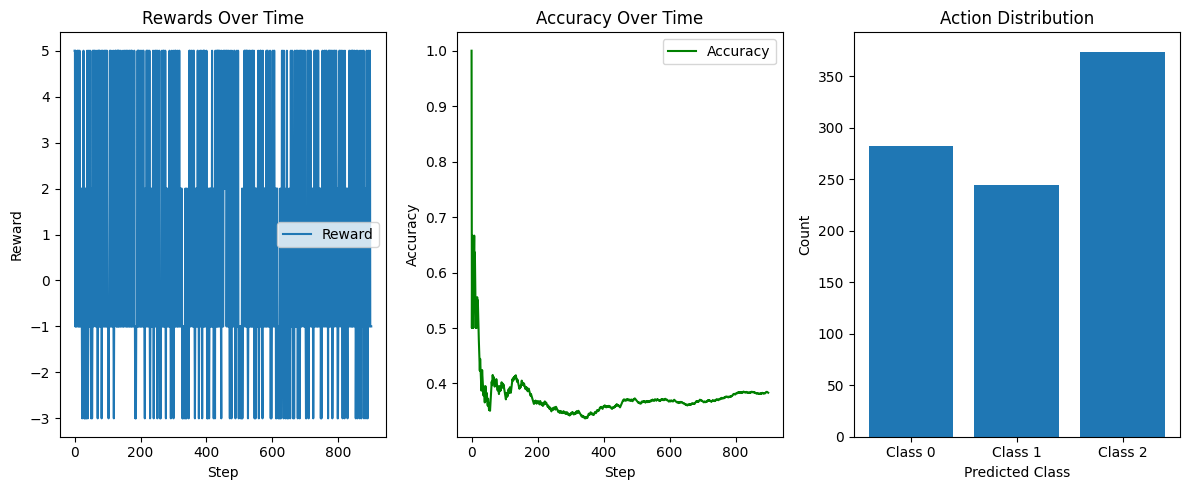

Action: 2, Reward: -1.0, Accuracy: 0.3833
Action: 2, Reward: 5.0, Accuracy: 0.3840
Action: 0, Reward: 5.0, Accuracy: 0.3847
Action: 2, Reward: -1.0, Accuracy: 0.3843
Action: 2, Reward: -1.0, Accuracy: 0.3838
Action: 1, Reward: 2.0, Accuracy: 0.3845
Action: 1, Reward: 2.0, Accuracy: 0.3852
Action: 1, Reward: -3.0, Accuracy: 0.3848
Action: 1, Reward: -3.0, Accuracy: 0.3844
Action: 1, Reward: 2.0, Accuracy: 0.3850
Action: 2, Reward: -1.0, Accuracy: 0.3846
Action: 2, Reward: -1.0, Accuracy: 0.3842
Action: 2, Reward: -1.0, Accuracy: 0.3838
Action: 2, Reward: -1.0, Accuracy: 0.3834
Action: 1, Reward: 2.0, Accuracy: 0.3840
Action: 2, Reward: 5.0, Accuracy: 0.3847
Action: 0, Reward: -1.0, Accuracy: 0.3843
Action: 1, Reward: 2.0, Accuracy: 0.3850
Action: 1, Reward: 2.0, Accuracy: 0.3856
Action: 1, Reward: 2.0, Accuracy: 0.3863
Action: 1, Reward: -3.0, Accuracy: 0.3859
Action: 2, Reward: 5.0, Accuracy: 0.3865
Action: 1, Reward: 2.0, Accuracy: 0.3872
Action: 1, Reward: 2.0, Accuracy: 0.3879
Actio

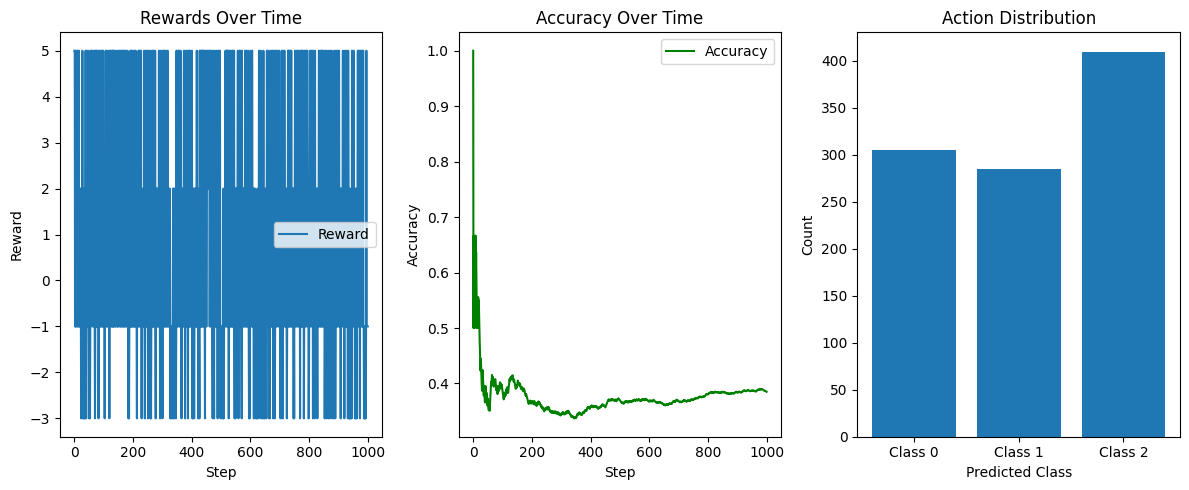

Action: 2, Reward: -1.0, Accuracy: 0.3850
Action: 1, Reward: 2.0, Accuracy: 0.3856
Action: 2, Reward: -1.0, Accuracy: 0.3852
Action: 1, Reward: -3.0, Accuracy: 0.3848
Action: 0, Reward: -1.0, Accuracy: 0.3845
Action: 1, Reward: 2.0, Accuracy: 0.3851
Action: 1, Reward: -3.0, Accuracy: 0.3847
Action: 2, Reward: 5.0, Accuracy: 0.3853
Action: 0, Reward: -1.0, Accuracy: 0.3849
Action: 2, Reward: -1.0, Accuracy: 0.3845
Action: 1, Reward: 2.0, Accuracy: 0.3851
Action: 2, Reward: 5.0, Accuracy: 0.3858
Action: 0, Reward: -1.0, Accuracy: 0.3854
Action: 0, Reward: 5.0, Accuracy: 0.3860
Action: 2, Reward: -1.0, Accuracy: 0.3856
Action: 2, Reward: -1.0, Accuracy: 0.3852
Action: 2, Reward: -1.0, Accuracy: 0.3848
Action: 1, Reward: -3.0, Accuracy: 0.3845
Action: 0, Reward: -1.0, Accuracy: 0.3841
Action: 2, Reward: -1.0, Accuracy: 0.3837
Action: 1, Reward: 2.0, Accuracy: 0.3843
Action: 1, Reward: -3.0, Accuracy: 0.3839
Action: 2, Reward: -1.0, Accuracy: 0.3836
Action: 2, Reward: -1.0, Accuracy: 0.3832

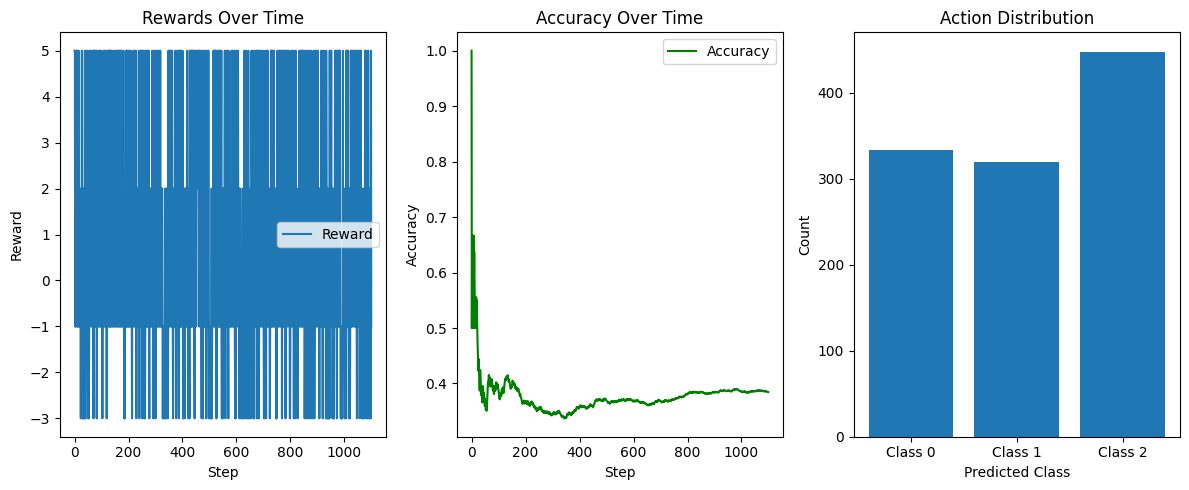

Action: 2, Reward: -1.0, Accuracy: 0.3845
Action: 1, Reward: 2.0, Accuracy: 0.3851
Action: 2, Reward: -1.0, Accuracy: 0.3848
Action: 2, Reward: -1.0, Accuracy: 0.3844
Action: 1, Reward: -3.0, Accuracy: 0.3841
Action: 0, Reward: 5.0, Accuracy: 0.3846
Action: 2, Reward: -1.0, Accuracy: 0.3843
Action: 1, Reward: 2.0, Accuracy: 0.3848
Action: 0, Reward: -1.0, Accuracy: 0.3845
Action: 0, Reward: 5.0, Accuracy: 0.3850
Action: 2, Reward: 5.0, Accuracy: 0.3856
Action: 0, Reward: -1.0, Accuracy: 0.3852
Action: 2, Reward: -1.0, Accuracy: 0.3849
Action: 1, Reward: -3.0, Accuracy: 0.3845
Action: 2, Reward: 5.0, Accuracy: 0.3851
Action: 0, Reward: -1.0, Accuracy: 0.3848
Action: 1, Reward: 2.0, Accuracy: 0.3853
Action: 0, Reward: -1.0, Accuracy: 0.3850
Action: 1, Reward: 2.0, Accuracy: 0.3855
Action: 2, Reward: 5.0, Accuracy: 0.3861
Action: 0, Reward: 5.0, Accuracy: 0.3866
Action: 2, Reward: -1.0, Accuracy: 0.3863
Action: 2, Reward: -1.0, Accuracy: 0.3859
Action: 0, Reward: -1.0, Accuracy: 0.3856
Ac

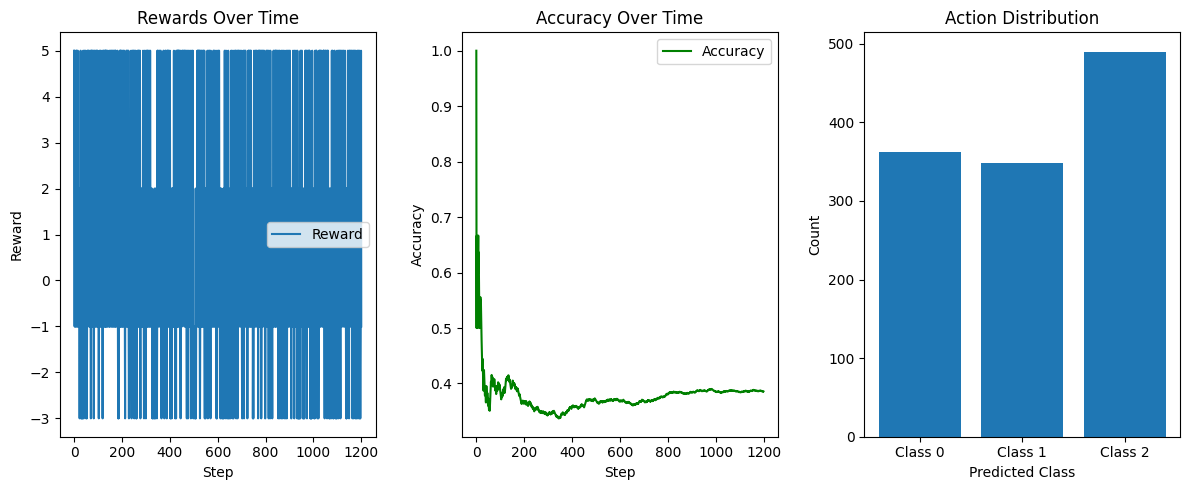

Action: 2, Reward: -1.0, Accuracy: 0.3858
Action: 1, Reward: -3.0, Accuracy: 0.3855
Action: 1, Reward: 2.0, Accuracy: 0.3860
Action: 1, Reward: 2.0, Accuracy: 0.3865
Action: 0, Reward: -1.0, Accuracy: 0.3862
Action: 0, Reward: -1.0, Accuracy: 0.3859
Action: 0, Reward: 5.0, Accuracy: 0.3864
Action: 2, Reward: -1.0, Accuracy: 0.3861
Action: 2, Reward: -1.0, Accuracy: 0.3858
Action: 2, Reward: -1.0, Accuracy: 0.3854
Action: 2, Reward: 5.0, Accuracy: 0.3860
Action: 1, Reward: 2.0, Accuracy: 0.3865
Action: 1, Reward: 2.0, Accuracy: 0.3870
Action: 0, Reward: 5.0, Accuracy: 0.3875
Action: 2, Reward: -1.0, Accuracy: 0.3871
Action: 1, Reward: 2.0, Accuracy: 0.3877
Action: 1, Reward: -3.0, Accuracy: 0.3873
Action: 1, Reward: 2.0, Accuracy: 0.3878
Action: 1, Reward: -3.0, Accuracy: 0.3875
Action: 2, Reward: -1.0, Accuracy: 0.3872
Action: 0, Reward: -1.0, Accuracy: 0.3869
Action: 2, Reward: -1.0, Accuracy: 0.3866
Action: 2, Reward: 5.0, Accuracy: 0.3871
Action: 0, Reward: -1.0, Accuracy: 0.3868
Ac

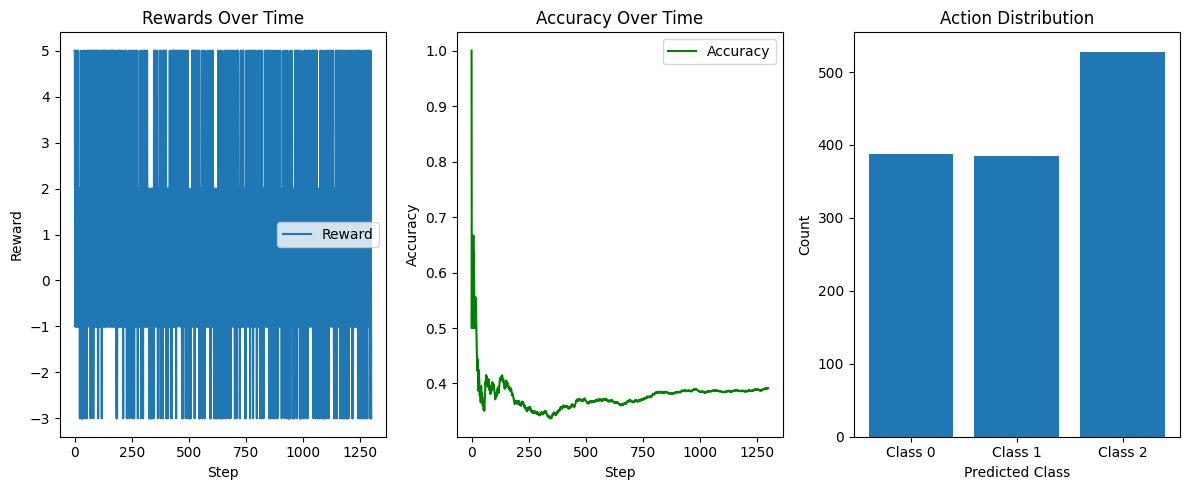

Action: 1, Reward: -3.0, Accuracy: 0.3915
Action: 1, Reward: 2.0, Accuracy: 0.3920
Action: 2, Reward: -1.0, Accuracy: 0.3917
Action: 2, Reward: -1.0, Accuracy: 0.3914
Action: 2, Reward: -1.0, Accuracy: 0.3911
Action: 2, Reward: -1.0, Accuracy: 0.3908
Action: 1, Reward: -3.0, Accuracy: 0.3905
Action: 2, Reward: -1.0, Accuracy: 0.3902
Action: 1, Reward: -3.0, Accuracy: 0.3899
Action: 1, Reward: 2.0, Accuracy: 0.3904
Action: 0, Reward: 5.0, Accuracy: 0.3908
Action: 2, Reward: -1.0, Accuracy: 0.3905
Action: 1, Reward: 2.0, Accuracy: 0.3910
Action: 2, Reward: 5.0, Accuracy: 0.3915
Action: 0, Reward: -1.0, Accuracy: 0.3912
Action: 1, Reward: 2.0, Accuracy: 0.3916
Action: 1, Reward: -3.0, Accuracy: 0.3913
Action: 2, Reward: -1.0, Accuracy: 0.3910
Action: 2, Reward: -1.0, Accuracy: 0.3907
Action: 2, Reward: 5.0, Accuracy: 0.3912
Action: 0, Reward: 5.0, Accuracy: 0.3917
Action: 2, Reward: -1.0, Accuracy: 0.3914
Action: 2, Reward: -1.0, Accuracy: 0.3911
Action: 1, Reward: 2.0, Accuracy: 0.3915
A

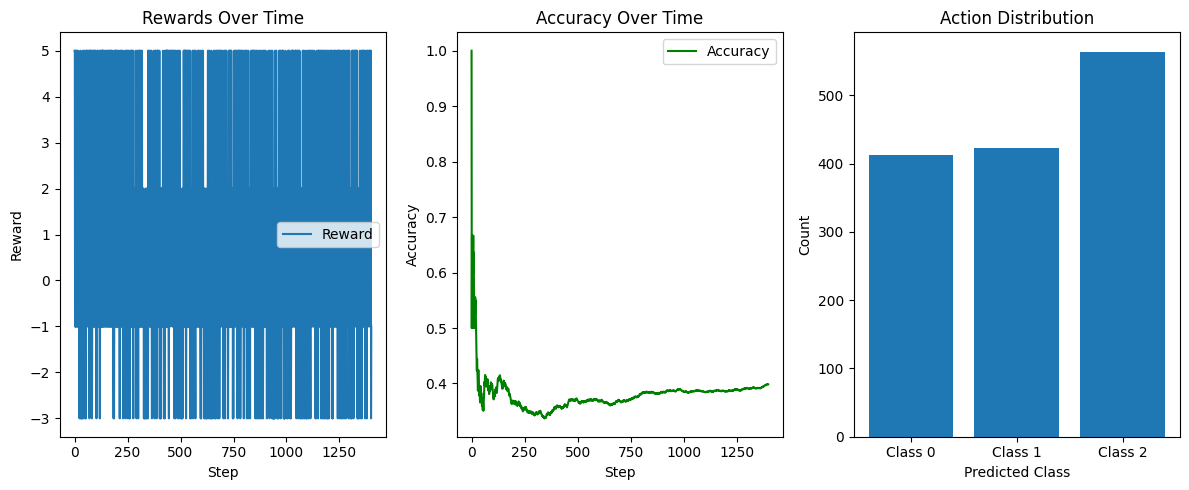

Action: 0, Reward: -1.0, Accuracy: 0.3986
Action: 2, Reward: -1.0, Accuracy: 0.3983
Action: 0, Reward: 5.0, Accuracy: 0.3987
Action: 2, Reward: -1.0, Accuracy: 0.3984
Action: 0, Reward: -1.0, Accuracy: 0.3981
Action: 1, Reward: 2.0, Accuracy: 0.3986
Action: 2, Reward: 5.0, Accuracy: 0.3990
Action: 0, Reward: -1.0, Accuracy: 0.3987
Action: 1, Reward: -3.0, Accuracy: 0.3984
Action: 2, Reward: -1.0, Accuracy: 0.3982
Action: 1, Reward: -3.0, Accuracy: 0.3979
Action: 1, Reward: 2.0, Accuracy: 0.3983
Action: 1, Reward: 2.0, Accuracy: 0.3987
Action: 2, Reward: -1.0, Accuracy: 0.3984
Action: 2, Reward: 5.0, Accuracy: 0.3989
Action: 1, Reward: 2.0, Accuracy: 0.3993
Action: 0, Reward: -1.0, Accuracy: 0.3990
Action: 1, Reward: -3.0, Accuracy: 0.3987
Action: 2, Reward: 5.0, Accuracy: 0.3992
Action: 0, Reward: -1.0, Accuracy: 0.3989
Action: 0, Reward: -1.0, Accuracy: 0.3986
Action: 1, Reward: -3.0, Accuracy: 0.3983
Action: 2, Reward: -1.0, Accuracy: 0.3980
Action: 2, Reward: -1.0, Accuracy: 0.3978


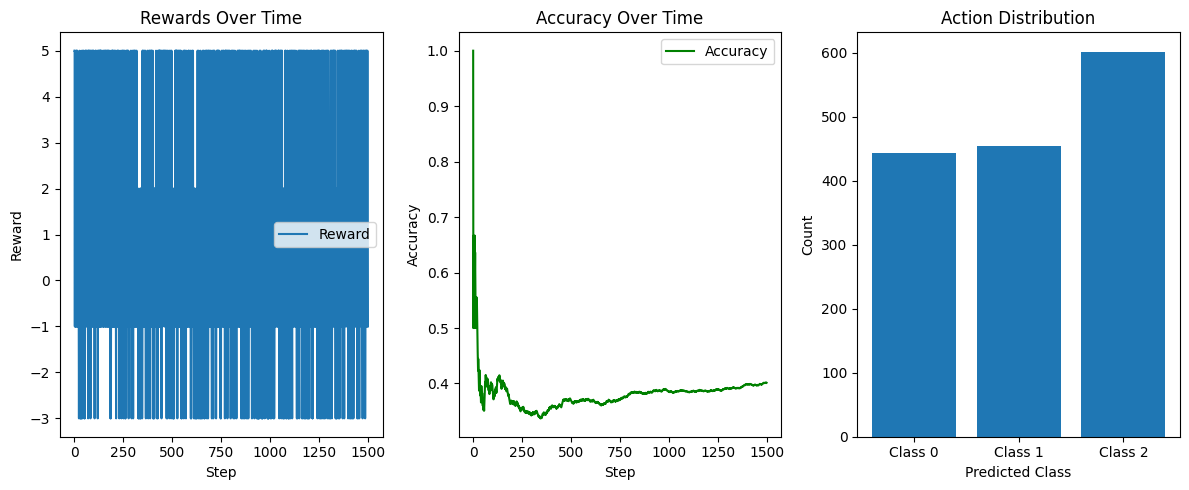

Action: 2, Reward: -1.0, Accuracy: 0.4013
Action: 2, Reward: -1.0, Accuracy: 0.4011
Action: 2, Reward: 5.0, Accuracy: 0.4015
Action: 0, Reward: -1.0, Accuracy: 0.4012
Action: 0, Reward: -1.0, Accuracy: 0.4009
Action: 2, Reward: -1.0, Accuracy: 0.4007
Action: 1, Reward: -3.0, Accuracy: 0.4004
Action: 2, Reward: 5.0, Accuracy: 0.4008
Action: 0, Reward: -1.0, Accuracy: 0.4005
Action: 2, Reward: -1.0, Accuracy: 0.4003
Action: 0, Reward: 5.0, Accuracy: 0.4007
Action: 1, Reward: 2.0, Accuracy: 0.4011
Action: 2, Reward: 5.0, Accuracy: 0.4015
Action: 0, Reward: -1.0, Accuracy: 0.4012
Action: 2, Reward: -1.0, Accuracy: 0.4009
Action: 2, Reward: -1.0, Accuracy: 0.4007
Action: 1, Reward: 2.0, Accuracy: 0.4011
Action: 2, Reward: -1.0, Accuracy: 0.4008
Action: 1, Reward: -3.0, Accuracy: 0.4005
Action: 2, Reward: -1.0, Accuracy: 0.4003
Action: 1, Reward: -3.0, Accuracy: 0.4000
Action: 0, Reward: -1.0, Accuracy: 0.3997
Action: 1, Reward: 2.0, Accuracy: 0.4001
Action: 0, Reward: -1.0, Accuracy: 0.3999

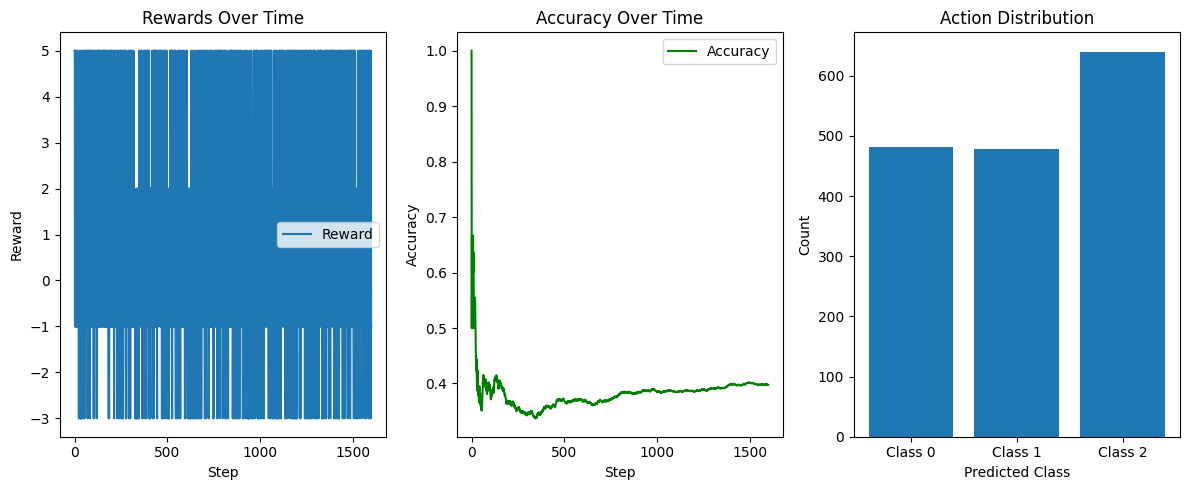

Action: 0, Reward: -1.0, Accuracy: 0.3975
Action: 1, Reward: 2.0, Accuracy: 0.3979
Action: 1, Reward: -3.0, Accuracy: 0.3976
Action: 0, Reward: -1.0, Accuracy: 0.3974
Action: 1, Reward: -3.0, Accuracy: 0.3971


KeyboardInterrupt: 

In [17]:
while not done:
    action, _ = model.predict(obs, deterministic=True)  # Get action
    action = int(action)  # Convert from NumPy array to int

    obs, reward, done, truncated, info = test_env.step(action)  # Step with int action

    # Optional: Print debugging info
    print(f"Action: {action}, Reward: {reward}, Accuracy: {info['accuracy']:.4f}")
